# Implementação de um contador automático de passageiros de ônibus
**Autores: Ronaldo Nunez e Vitor Lima**

**Disciplina IA898-A: Processamento digital de Imagens**

### Importando as dependências

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pims
from PIL import Image

#### Funções auxiliares

In [2]:
 def histogram(img, bins, range):
    h, be = np.histogram(img, bins=bins, range=range)
    w = range[-1]/bins
    bin_centers = be[1:]-(w/2)
    
    return bin_centers, h, w

In [3]:
def frame_analysis(frame_orig, frame_proc):
    tfig = plt.figure()

    tfig0 = plt.subplot2grid((4, 4), (0, 0), rowspan=2, colspan=2)
    tfig1 = plt.subplot2grid((4, 4), (0, 2), rowspan=2, colspan=2)
    tfig2 = plt.subplot2grid((4, 4), (2, 0), rowspan=2, colspan=4)
    
    tfig0.set_title('Frame original')
    tfig0.axis('off')
    tfig0.imshow(frame_orig, cmap='gray')

    tfig1.set_title('Frame subtraido')
    tfig1.axis('off')
    tfig1.imshow(frame_proc, cmap='gray')

    (bc, h , w) = histogram(frame_proc, 120, (0, 1.0))
    
    tfig2.bar(bc, h, width=w)

In [4]:
# Fonte: https://code.i-harness.com/en/q/c53fb2
def unique(array):
    uniq, index = np.unique(array, axis=0, return_index=True)
    return uniq[index.argsort()]

In [5]:
def to_gray(video):
    frames, width, hight, color = video.shape
    video_gray = np.zeros((frames, width, hight), dtype='uint32')
    
    for ii in range(len(video)):
        r, g, b = Image.fromarray(video[ii]).split()
        
        r = np.array(r, dtype='uint32')
        g = np.array(g, dtype='uint32')
        b = np.array(b, dtype='uint32')
        
        video_gray[ii] = (r + g + b) / 3
        
    return video_gray

### Abrindo os vídeos

In [6]:
v = pims.Video('../dataset/25_20160407_front/normal/crowd/2016_04_07_06_49_39FrontColor.avi')
# v = pims.Video('../dataset/25_20160407_front/normal/crowd/2016_04_07_13_36_24FrontColor.avi')

Algumas informações sobre o vídeo aberto:

In [7]:
print(v.get_metadata())

v_array = np.array(v)
print('\n', v_array.shape)

N_frames = v_array.shape[0]
width = v_array.shape[1]
height = v_array.shape[2]
channel_colors = v_array.shape[3]

{'plugin': 'ffmpeg', 'nframes': 322, 'ffmpeg_version': 'N-86111-ga441aa90e8-static http://johnvansickle.com/ffmpeg/ built with gcc 5.4.1 (Debian 5.4.1-8) 20170304', 'fps': 25.0, 'source_size': (320, 240), 'size': (320, 240), 'duration': 12.88}

 (322, 240, 320, 3)


Os campos da *tupla* anterior significam o seguinte:
(Frames, Altura, Largura, Cores)

### Pré-processamento

### Convertendo o vídeo para escala de cinza

In [8]:
I = to_gray(v_array)
I.shape
# play(x[0:30])

(322, 240, 320)

### Determinando o modelo de fundo

#### Background Modeling Independent of Time

In [9]:
tao = 0.98  # Threshold

In [10]:
def fgmask_BMIT(video, tao):
    B_BMIT = video[0] # background model
    D_BMIT = np.abs(video - B_BMIT) # background subtraction

    # foreground mask
    F_BMIT = D_BMIT.copy() 
    F_BMIT = F_BMIT / F_BMIT.max()
    F_BMIT[F_BMIT >= tao] = 1.0
    F_BMIT[F_BMIT < tao] = 0
    
    return F_BMIT

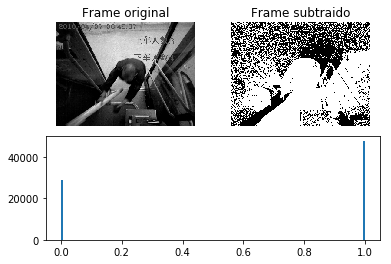

In [11]:
F_BMIT = fgmask_BMIT(I, 0.98)
frame_analysis(I[47], F_BMIT[47])

####  The Long Term Average Background Modeling

In [12]:
tao_LTAMBM = 0.2

def fgmask_LTABM(video, tao):
    # backgound model
    B_LTAMBM = np.zeros(video.shape)
    for k in range(1, len(video)):
        B_LTAMBM[k] = (1-1/k)*B_LTAMBM[k-1] + (1/k) *video[k]

    D_LTAMBM = np.abs(video - B_LTAMBM) # background subtraction

    # foreground mask
    F_LTAMBM = D_LTAMBM.copy() 
    F_LTAMBM = F_LTAMBM / F_LTAMBM.max()
    F_LTAMBM[F_LTAMBM >= tao_LTAMBM] = 1.0
    F_LTAMBM[F_LTAMBM < tao_LTAMBM] = 0
    
    return F_LTAMBM

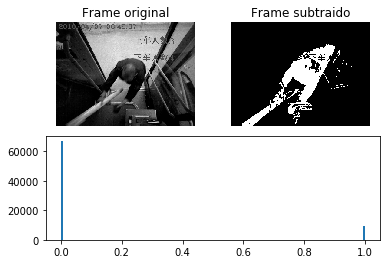

In [13]:
F_LTAMBM = fgmask_LTABM(I, 0.2)
# frame_analysis(I[47], D_LTAMBM[47])
frame_analysis(I[47], F_LTAMBM[47])

#### Moving Average Backgound Modeling

In [14]:
tao_MABM = 0.2

def fgmodel_MABM(video, tao):
    # background modeling
    W = 10
    B_MABM = np.zeros(video.shape)
    for k in range((W-1), len(video)-1):
        B_MABM[k] = (1/W)*np.sum(video[(k-(W-1)):(k+1),:,:], axis=0)

    D_MABM = np.abs(video - B_MABM) # background subtraction

    # foreground mask
    F_MABM = D_MABM.copy() 
    F_MABM = F_MABM / F_MABM.max()
    F_MABM[F_MABM >= tao] = 1.0
    F_MABM[F_MABM < tao] = 0
    
    return F_MABM

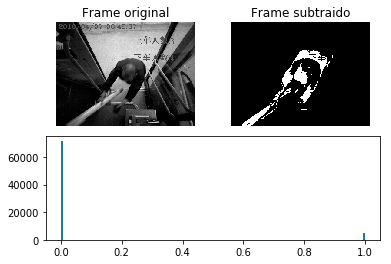

In [15]:
F_MABM = fgmodel_MABM(I, 0.2)
frame_analysis(I[47], F_MABM[47])

### Detecção

In [16]:
print(I.shape)

H = I.shape[1] # altura, em pixels, na direção do fluxo
W = I.shape[2] # largura, em pixels, perpendicular ao fluxo
print('H = {}, W = {}'.format(H, W))

K = 10
Theta = 0.2

(322, 240, 320)
H = 240, W = 320


In [17]:
def active_strips(foregd_frame, Theta, H, W, K):
    delta = W / K

    C_area = delta * H/2
    A = np.array([], dtype='uint32')

    for C_i in np.hsplit(foregd_frame, K):
        for C_j in np.vsplit(C_i, 2):
            aux = 1 if ((C_j == 1).sum() >= C_area*Theta) else 0
            A = np.append(A, aux)

    A = np.vstack((A[0::2], A[1::2]))
    
    return A

In [18]:
def active_strips_changes(fgmodel_video, Theta, H, W, K):
    A_vid = np.zeros((fgmodel_video.shape[0], 2, K))

    i = 0
    for frame in fgmodel_video:
        A_vid[i] = active_strips(frame, 0.21, H, W, K)
        i += 1

    return unique(A_vid)

In [19]:
A_teste = active_strips_changes(F_MABM, 0.2, I.shape[1], I.shape[2], 10)

### Contagem automática

In [20]:
def people_counter(asc_video):
    people = 0

    for f in range(1, asc_video.shape[0]):
        for i in range(asc_video.shape[2]):
            if ((asc_video[f-1, 0, i] == 1) and 
                (asc_video[f-1, 1, i] == 0) and
                (asc_video[f, 1, i] == 1) ):
                people += 1

    return people

In [21]:
people_counter(A_teste)

1